In [1]:
!pip install afinn

You should consider upgrading via the 'C:\Users\HP\anaconda3\python.exe -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from googletrans import Translator
from afinn import Afinn
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import matplotlib.pyplot as plt
from textblob import TextBlob
import nltk
import re
import time

STOP_WORDS= stopwords.words('portuguese')
STOP_WORDS_ENG = stopwords.words('english')

In [24]:
reviews = pd.read_csv('review.csv')

In [38]:
products = pd.read_csv('olist_products_dataset.csv')

In [4]:
ord_items = pd.read_csv('items.csv')

In [41]:
trans = pd.read_csv('product_category_name_translation.csv')

In [85]:
reviews.shape

(99224, 7)

In [ ]:
-----------------------------------------------------------------------------------------------------------------

In [25]:
reviews = pd.read_csv('review.csv')

In [26]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  
                           u"\U0001F300-\U0001F5FF"  
                           u"\U0001F680-\U0001F6FF"  
                           u"\U0001F1E0-\U0001F1FF"  
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

reviews.review_comment_message = reviews.review_comment_message.apply(lambda text: remove_emoji(str(text)))
reviews.head(3)


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,nan,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,nan,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,nan,2018-02-17 00:00:00,2018-02-18 14:36:24


In [28]:
def translate_to_english(text):
    if not pd.isna(text):
        text= " ".join([word for word in word_tokenize(text) if word not in STOP_WORDS])
        translator = Translator()
        t_text = translator.translate(text, src= 'pt', dest= 'en').text
        return t_text
    else :
        return np.NaN
translate_to_english(str(reviews['review_comment_message']))

'0 NAN 1 NAN 2 NAN 3 I received well before stipulated period.4 Congratulations Lannister Stores I loved buying i ... ... 99219 NAN 99220 NAN 99221 Excellent backpack, super fast delivery.Super ... 99222 nan 99223 Product arrived already returned, po ... name: review_comment_message, length: 99224, dtype: object'

In [ ]:
cols = list(reviews.columns)
cols.append('product_id')
prod_review = pd.DataFrame(columns= cols)

def product_review(prod):
    
    global prod_review
    oid = ord_items[ord_items.product_id == prod].order_id
    rid = reviews[reviews.order_id.isin(oid)].review_id
    data = reviews[reviews.review_id.isin(rid)].copy()
    data['product_id'] = prod
    prod_review = pd.concat([prod_review,data], ignore_index=True)
    
products.product_id.apply(product_review)

In [ ]:
prod_review.to_csv('product_review.csv', index= False)

In [29]:
df = pd.read_csv('product_review.csv')

<ipython-input-29-7d833fa4802b>:1: DtypeWarning: Columns (2,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('product_review.csv')


In [ ]:
def translate_to_english(text):
    if not pd.isna(text):
        text= " ".join([word for word in word_tokenize(text) if word not in STOP_WORDS])
        translator = Translator()
        t_text = translator.translate(text, src= 'pt', dest= 'en').text
        return t_text
    else :
        return np.NaN

In [ ]:
lower = 0
upper = 250
limit = 104670
rem = 170
step = 500

while(upper < limit):
    df.loc[lower:upper,'review_eng']= df.review_comment_message.iloc[lower:upper].apply(translate_to_english)
    print('Completed: ',upper)
    lower = upper
    upper += step
    time.sleep(300)

df.loc[limit:,'review_eng']= df.review_comment_message.iloc[limit:].apply(translate_to_english) 

In [30]:
df.review_eng.replace('nan', np.NaN, inplace= True)
eng_reviews = df.dropna(subset= ['review_eng'])
eng_reviews = eng_reviews[['product_id', 'review_eng', 'review_score']]

In [31]:
def preprocessing(text):
    text = re.sub('[\W]+',' ', text)
    text = text.lower()
    words = word_tokenize(text)
    return " ".join([word for word in words if word not in STOP_WORDS_ENG])

eng_reviews.review_eng = eng_reviews.review_eng.apply(preprocessing)
eng_reviews.sample(3)

,product_id,review_eng,review_score
21424,7501e40e8bc7a7db7c2f4b005e1dddcb,forwards received great condition,4
11700,c5edc6d6a54cbcc12367409391fdfc50,good,5
9060,656e0eca68dcecf6a31b8ececfabe3e8,long wait,1


In [100]:
eng_reviews.shape

(10109, 3)

In [32]:
af = Afinn()

score_afinn = eng_reviews.review_eng.apply(lambda text: af.score(text))
sentiment_afinn = score_afinn.apply(lambda s: 'positive' if s > 0 else 'negative' if s < 0 else 'neutral')

afinn_reviews = pd.concat([eng_reviews.product_id, score_afinn, sentiment_afinn], axis=1)
afinn_reviews.columns= ['product_id', 'score', 'sentiment']
afinn_reviews.sample(3)

,product_id,score,sentiment
8308,7e48d9554094858ee2269c4ef809f50e,0.0,neutral
4341,a1013e8a0647368039fc1a2f7cd5e516,2.0,positive
14185,f7a17d2c51d9df89a4f1711c4ac17f33,0.0,neutral


In [46]:
t = afinn_reviews.merge(products, on ='product_id')

In [48]:
t = t.merge(trans, on = 'product_category_name')

In [49]:
t

,product_id,score,sentiment,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,1e9e8ef04dbcff4541ed26657ea517e5,-2.0,negative,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery
1,6a2fb4dd53d2cdb88e0432f1284a004c,3.0,positive,perfumaria,39.0,346.0,2.0,400.0,27.0,5.0,20.0,perfumery
2,0d009643171aee696f4733340bc2fdd0,0.0,neutral,perfumaria,52.0,150.0,1.0,422.0,21.0,16.0,18.0,perfumery
3,0d009643171aee696f4733340bc2fdd0,0.0,neutral,perfumaria,52.0,150.0,1.0,422.0,21.0,16.0,18.0,perfumery
4,0d009643171aee696f4733340bc2fdd0,2.0,positive,perfumaria,52.0,150.0,1.0,422.0,21.0,16.0,18.0,perfumery
...,...,...,...,...,...,...,...,...,...,...,...,...
9961,7620a27f1d6747511f1c6f0ddb63c0ef,3.0,positive,flores,52.0,225.0,1.0,850.0,16.0,11.0,11.0,flowers
9962,7620a27f1d6747511f1c6f0ddb63c0ef,0.0,neutral,flores,52.0,225.0,1.0,850.0,16.0,11.0,11.0,flowers
9963,7620a27f1d6747511f1c6f0ddb63c0ef,2.0,positive,flores,52.0,225.0,1.0,850.0,16.0,11.0,11.0,flowers
9964,7620a27f1d6747511f1c6f0ddb63c0ef,0.0,neutral,flores,52.0,225.0,1.0,850.0,16.0,11.0,11.0,flowers


In [11]:
#test = afinn_reviews.merge(products, on = 'product_id').merge(trans, on = 'product_category_name')

In [13]:
#test

,product_id,score,sentiment,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,1e9e8ef04dbcff4541ed26657ea517e5,-2.0,negative,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery
1,6a2fb4dd53d2cdb88e0432f1284a004c,3.0,positive,perfumaria,39.0,346.0,2.0,400.0,27.0,5.0,20.0,perfumery
2,0d009643171aee696f4733340bc2fdd0,0.0,neutral,perfumaria,52.0,150.0,1.0,422.0,21.0,16.0,18.0,perfumery
3,0d009643171aee696f4733340bc2fdd0,0.0,neutral,perfumaria,52.0,150.0,1.0,422.0,21.0,16.0,18.0,perfumery
4,0d009643171aee696f4733340bc2fdd0,2.0,positive,perfumaria,52.0,150.0,1.0,422.0,21.0,16.0,18.0,perfumery
...,...,...,...,...,...,...,...,...,...,...,...,...
9961,7620a27f1d6747511f1c6f0ddb63c0ef,3.0,positive,flores,52.0,225.0,1.0,850.0,16.0,11.0,11.0,flowers
9962,7620a27f1d6747511f1c6f0ddb63c0ef,0.0,neutral,flores,52.0,225.0,1.0,850.0,16.0,11.0,11.0,flowers
9963,7620a27f1d6747511f1c6f0ddb63c0ef,2.0,positive,flores,52.0,225.0,1.0,850.0,16.0,11.0,11.0,flowers
9964,7620a27f1d6747511f1c6f0ddb63c0ef,0.0,neutral,flores,52.0,225.0,1.0,850.0,16.0,11.0,11.0,flowers


In [14]:
#test = test.drop(test.iloc[:,3:11], axis =1)

In [15]:
#test

,product_id,score,sentiment,product_category_name_english
0,1e9e8ef04dbcff4541ed26657ea517e5,-2.0,negative,perfumery
1,6a2fb4dd53d2cdb88e0432f1284a004c,3.0,positive,perfumery
2,0d009643171aee696f4733340bc2fdd0,0.0,neutral,perfumery
3,0d009643171aee696f4733340bc2fdd0,0.0,neutral,perfumery
4,0d009643171aee696f4733340bc2fdd0,2.0,positive,perfumery
...,...,...,...,...
9961,7620a27f1d6747511f1c6f0ddb63c0ef,3.0,positive,flowers
9962,7620a27f1d6747511f1c6f0ddb63c0ef,0.0,neutral,flowers
9963,7620a27f1d6747511f1c6f0ddb63c0ef,2.0,positive,flowers
9964,7620a27f1d6747511f1c6f0ddb63c0ef,0.0,neutral,flowers


In [33]:
review_sentiments = afinn_reviews.groupby('product_id').agg({'score':'mean','sentiment':pd.Series.mode})

review_sentiments = review_sentiments.sort_values('score', ascending= False)
review_sentiments[:20]

,score,sentiment
product_id,,
37664a6100bf523c545b7040be69ad00,17.0,positive
f71954485428cf87945953ea0a0a6229,16.0,positive
f82a4b08cf7b2bf375fb77e519231f9a,16.0,positive
c696cd2db7870be08c37822f7c0ef831,15.0,positive
92857a2b590adeae8d5992511dc197e9,15.0,positive
1574ed2c73e4465c572f68dd77528203,14.0,positive
12e479f1c2c0417147a3e36302485e30,14.0,positive
4563095e06df1fa67de2eade86f4f01b,14.0,positive
0c96091f6f20b1d2c946a933370782a4,14.0,positive


In [56]:
review_sentiments = review_sentiments.merge(products, on = 'product_id').merge(trans, on = 'product_category_name')

(4301, 12)

In [34]:
def get_all_text(t):
    global text
    text = text+t+" "

(-0.5, 1199.5, 799.5, -0.5)

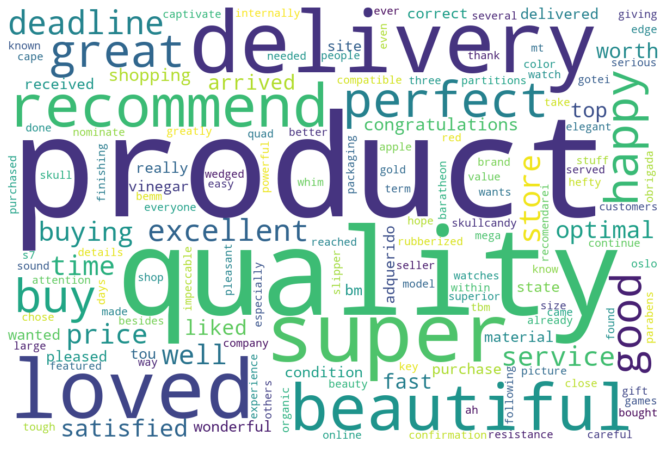

In [35]:
text = ""

tmp = eng_reviews[eng_reviews.product_id.isin(review_sentiments.index[:20])]
tmp.review_eng.apply(get_all_text)

wordcloud = WordCloud(
    width= 1200,
    height= 800,
    stopwords= STOP_WORDS_ENG,
    background_color= 'white'
).generate(text)

plt.figure(figsize= (12,8))
plt.imshow(wordcloud, interpolation= 'bilinear')
plt.axis('off')

In [36]:
review_sentiments[-20:]

,score,sentiment
product_id,,
77e8ff91e2cccad62b30a0a83bec431e,-6.0,negative
0cf3ab3383c2ae6f5750e5847c749e22,-6.0,negative
24c855c83d506d85c7386ff94d6c8db1,-6.0,negative
9e88896ff9b39f42a9652dc0730ecabc,-6.0,negative
1a0ef485e35802dd1d23ab5446cac458,-6.0,negative
093cd981b714bcdff182b427d87fc8fc,-6.0,negative
07797d4315ce5c1570e0a484472e04b5,-6.0,negative
ea768069ca084e95a752ee7d51a8ff70,-6.0,negative
d5abd3b28e2a7a0da8f0a4617f9188d6,-6.0,negative


(-0.5, 1199.5, 799.5, -0.5)

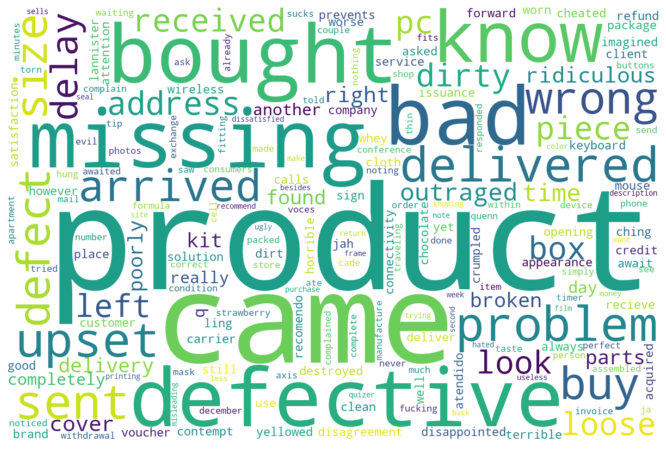

In [37]:
text = ""

tmp = eng_reviews[eng_reviews.product_id.isin(review_sentiments.index[-20:])]
tmp.review_eng.apply(get_all_text)

wordcloud = WordCloud(
    width= 1200,
    height= 800,
    stopwords= STOP_WORDS_ENG,
    background_color= 'white'
).generate(text)

plt.figure(figsize= (12,8))
plt.imshow(wordcloud, interpolation= 'bilinear')
plt.axis('off')